### 1. Imports and Setup

In [ ]:
import os
import shutil
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import kagglehub
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    Reshape, LSTM, GRU, Bidirectional, Input,
    Concatenate, Multiply
)
from tensorflow.keras.preprocessing import image
from transformers import ViTImageProcessor, TFViTForImageClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.18.0


### 2. Data Downloading and Preparation

In [ ]:
try:
    path = kagglehub.dataset_download("marcozuppelli/stegoimagesdataset")
    print("Path to dataset files:", path)
    source_path = path
    destination_path = '/content/stegoimagesdataset'

    if os.path.exists(destination_path):
        shutil.rmtree(destination_path)
    os.makedirs(destination_path, exist_ok=True)

    for item in os.listdir(source_path):
        s = os.path.join(source_path, item)
        d = os.path.join(destination_path, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, dirs_exist_ok=True)
        else:
            shutil.copy2(s, d)
    print(f"Data copied to {destination_path}")
except Exception as e:
    print(f"Could not download from Kaggle Hub. Error: {e}")
    destination_path = '/content/stegoimagesdataset'
    if not os.path.exists(destination_path):
        raise FileNotFoundError("Dataset not found.")

Path to dataset files: /kaggle/input/stegoimagesdataset
Data copied to /content/stegoimagesdataset


In [ ]:
def segregate_data_by_payload(original_data_path, new_base_path):
    print("\nSegregating data by payload type...")
    for split in ['train', 'test', 'val']:
        stego_path = os.path.join(original_data_path, split, split, 'stego')
        clean_path = os.path.join(original_data_path, split, split, 'clean')
        new_split_path = os.path.join(new_base_path, split)

        if os.path.exists(stego_path):
            for img_name in os.listdir(stego_path):
                try:
                    payload_class = img_name.split("_")[2]
                    class_dir = os.path.join(new_split_path, payload_class)
                    os.makedirs(class_dir, exist_ok=True)
                    shutil.copy(os.path.join(stego_path, img_name), class_dir)
                except IndexError:
                    print(f"Skipping file with unexpected name format: {img_name}")

        if os.path.exists(clean_path):
            new_clean_path = os.path.join(new_split_path, 'clean')
            shutil.copytree(clean_path, new_clean_path, dirs_exist_ok=True)
    print("Data segregation complete.")

new_data_path = "new_data"
if os.path.exists(new_data_path):
    shutil.rmtree(new_data_path)
segregate_data_by_payload(destination_path, new_data_path)


Segregating data by payload type...
Data segregation complete.


In [ ]:
def combine_and_resplit(source_base_path, final_base_path, train_ratio=0.8, test_ratio=0.1):
    print("\nCombining and re-splitting data...")
    all_files_by_class = {}
    for class_name in os.listdir(os.path.join(source_base_path, 'train')):
        all_files_by_class[class_name] = []
        for split in ['train', 'test', 'val']:
            class_folder = os.path.join(source_base_path, split, class_name)
            if os.path.exists(class_folder):
                all_files_by_class[class_name].extend([os.path.join(class_folder, f) for f in os.listdir(class_folder)])

    if os.path.exists(final_base_path):
        shutil.rmtree(final_base_path)

    for class_name, files in all_files_by_class.items():
        train_files, temp_files = train_test_split(files, train_size=train_ratio, random_state=42)
        val_ratio = 1 - (test_ratio / (1 - train_ratio))
        val_files, test_files = train_test_split(temp_files, train_size=val_ratio, random_state=42)

        for split_name, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
            dest_dir = os.path.join(final_base_path, split_name, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            for f in file_list:
                shutil.copy(f, dest_dir)
    print("Data re-splitting complete.")

final_data_path = "final_payload_data"
combine_and_resplit(new_data_path, final_data_path)


Combining and re-splitting data...
Data re-splitting complete.


In [ ]:
IMG_SIZE_GENERAL = 512
IMG_SIZE_VIT = 224
BATCH_SIZE = 128

print(f"\nLoading data for general models (CNN, RNNs) with image size {IMG_SIZE_GENERAL}x{IMG_SIZE_GENERAL}...")
train_dataset_gen = tf.keras.utils.image_dataset_from_directory(
    os.path.join(final_data_path, "train"),
    labels='inferred', label_mode='int',
    image_size=(IMG_SIZE_GENERAL, IMG_SIZE_GENERAL),
    batch_size=BATCH_SIZE, shuffle=True, seed=123
)
val_dataset_gen = tf.keras.utils.image_dataset_from_directory(
    os.path.join(final_data_path, "val"),
    labels='inferred', label_mode='int',
    image_size=(IMG_SIZE_GENERAL, IMG_SIZE_GENERAL),
    batch_size=BATCH_SIZE, shuffle=False, seed=123
)
test_dataset_gen = tf.keras.utils.image_dataset_from_directory(
    os.path.join(final_data_path, "test"),
    labels='inferred', label_mode='int',
    image_size=(IMG_SIZE_GENERAL, IMG_SIZE_GENERAL),
    batch_size=BATCH_SIZE, shuffle=False
)

print(f"\nLoading data for ViT model with image size {IMG_SIZE_VIT}x{IMG_SIZE_VIT}...")
train_dataset_vit = tf.keras.utils.image_dataset_from_directory(
    os.path.join(final_data_path, "train"),
    labels='inferred', label_mode='int',
    image_size=(IMG_SIZE_VIT, IMG_SIZE_VIT),
    batch_size=BATCH_SIZE, shuffle=True, seed=123
)
val_dataset_vit = tf.keras.utils.image_dataset_from_directory(
    os.path.join(final_data_path, "val"),
    labels='inferred', label_mode='int',
    image_size=(IMG_SIZE_VIT, IMG_SIZE_VIT),
    batch_size=BATCH_SIZE, shuffle=False, seed=123
)
test_dataset_vit = tf.keras.utils.image_dataset_from_directory(
    os.path.join(final_data_path, "test"),
    labels='inferred', label_mode='int',
    image_size=(IMG_SIZE_VIT, IMG_SIZE_VIT),
    batch_size=BATCH_SIZE, shuffle=False
)

class_names = train_dataset_gen.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")


Loading data for general models (CNN, RNNs) with image size 512x512...
Found 25599 files belonging to 6 classes.
Found 3197 files belonging to 6 classes.
Found 3204 files belonging to 6 classes.

Loading data for ViT model with image size 224x224...
Found 25599 files belonging to 6 classes.
Found 3197 files belonging to 6 classes.
Found 3204 files belonging to 6 classes.
Found 6 classes: ['clean', 'eth', 'html', 'js', 'ps', 'url']


Counting images for train set...
Counting images for val set...
Counting images for test set...

Overall Class Distribution:
- clean: 8000
- eth: 4913
- html: 4613
- js: 4765
- ps: 4845
- url: 4864

Plotting Class Distributions...


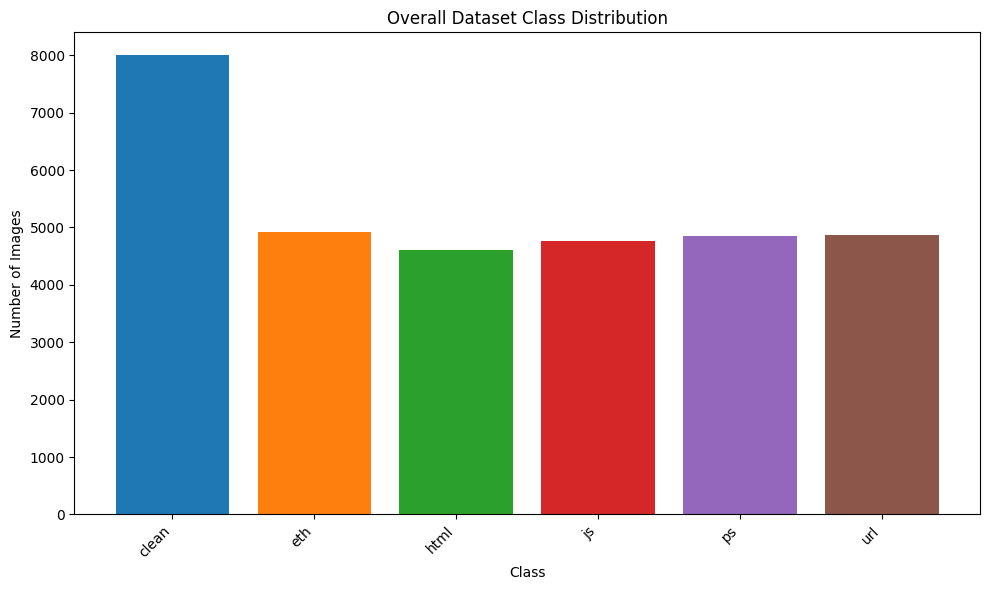


Plotting Combined Class Distributions...


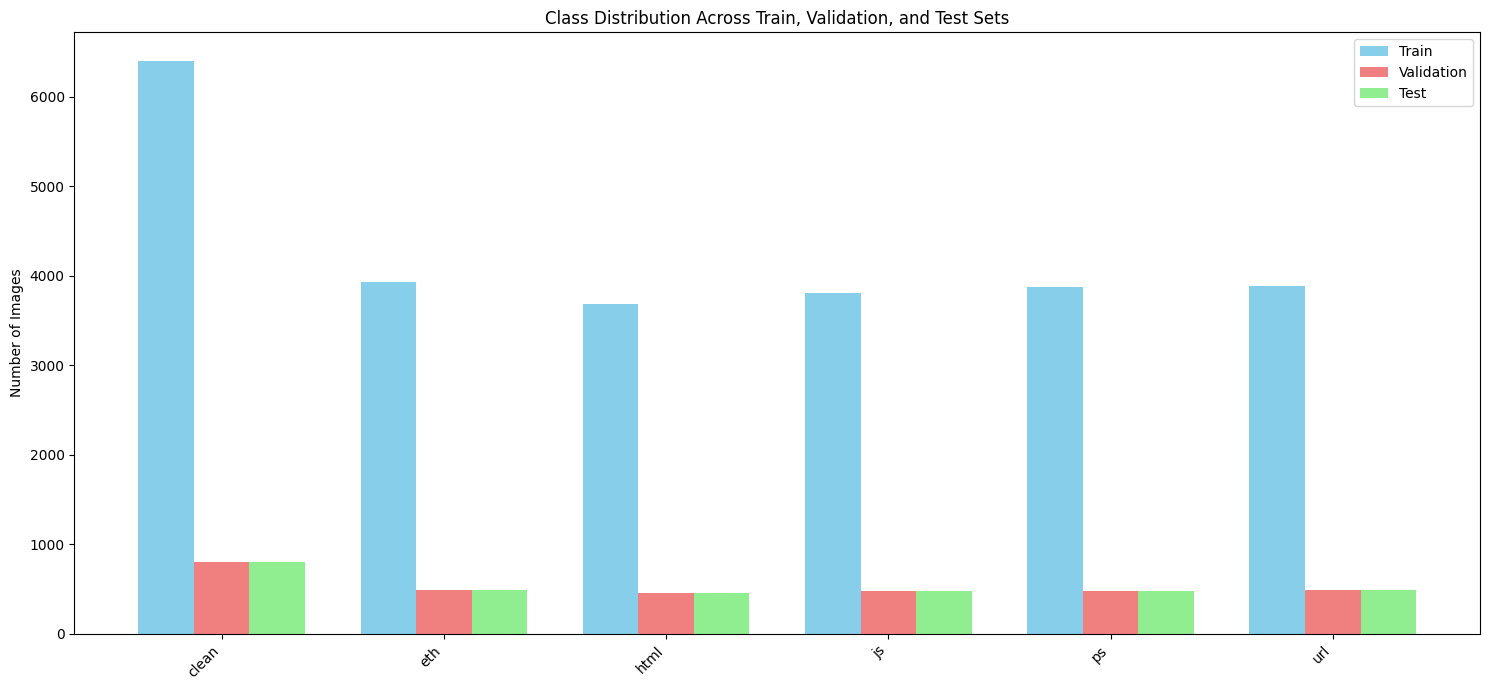

In [ ]:
# Function to count images per class in a directory
def count_images_per_class(data_path, split_name):
    print(f"Counting images for {split_name} set...")
    class_counts = {}
    split_path = os.path.join(data_path, split_name)
    if not os.path.exists(split_path):
        print(f"Warning: {split_name} directory not found at {split_path}")
        return class_counts

    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

# Count for each split
train_class_counts = count_images_per_class(final_data_path, 'train')
val_class_counts = count_images_per_class(final_data_path, 'val')
test_class_counts = count_images_per_class(final_data_path, 'test')

# Combine counts for overall distribution
all_class_names = sorted(list(set(train_class_counts.keys()) | set(val_class_counts.keys()) | set(test_class_counts.keys())))
overall_class_counts = {class_name: train_class_counts.get(class_name, 0) + val_class_counts.get(class_name, 0) + test_class_counts.get(class_name, 0) for class_name in all_class_names}

print("\nOverall Class Distribution:")
for class_name, count in overall_class_counts.items():
    print(f"- {class_name}: {count}")

# Plotting class distribution
def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    colors = matplotlib.colormaps.get_cmap('tab10') # Use matplotlib.colormaps.get_cmap with only the name

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color=colors.colors[:len(classes)]) # Use the generated colors and slice to match number of classes
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plotting combined class distribution for train, val, and test sets
def plot_combined_class_distribution(train_counts, val_counts, test_counts, all_class_names):
    print("\nPlotting Combined Class Distributions...")
    x = np.arange(len(all_class_names))
    width = 0.25

    fig, ax = plt.subplots(figsize=(15, 7))

    rects1 = ax.bar(x - width, [train_counts.get(c, 0) for c in all_class_names], width, label='Train', color='skyblue')
    rects2 = ax.bar(x, [val_counts.get(c, 0) for c in all_class_names], width, label='Validation', color='lightcoral')
    rects3 = ax.bar(x + width, [test_counts.get(c, 0) for c in all_class_names], width, label='Test', color='lightgreen')

    ax.set_ylabel('Number of Images')
    ax.set_title('Class Distribution Across Train, Validation, and Test Sets')
    ax.set_xticks(x)
    ax.set_xticklabels(all_class_names, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()
    plt.show()


print("\nPlotting Class Distributions...")
plot_class_distribution(overall_class_counts, "Overall Dataset Class Distribution")
plot_combined_class_distribution(train_class_counts, val_class_counts, test_class_counts, all_class_names)


Displaying sample images from each class...

Class: clean


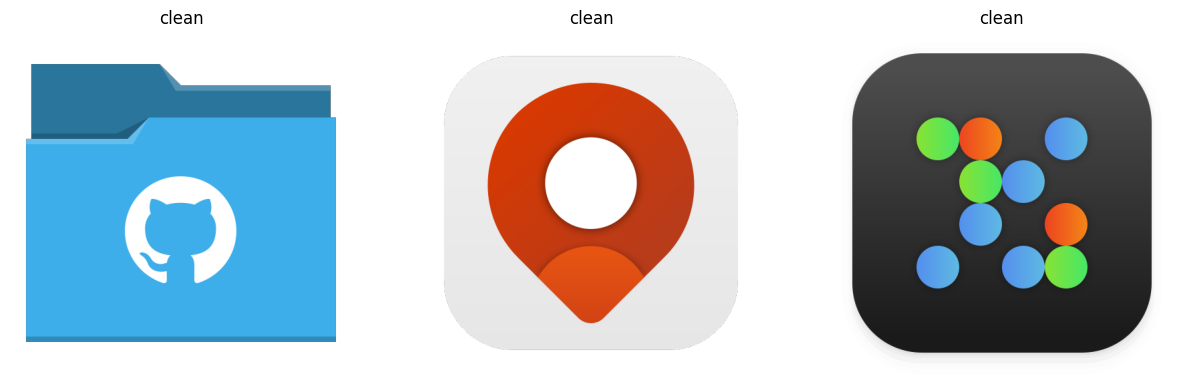


Class: eth


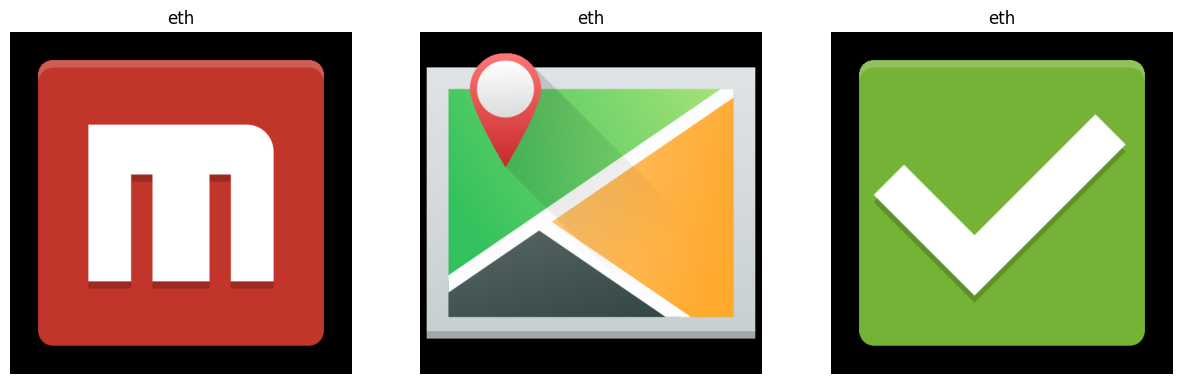


Class: html


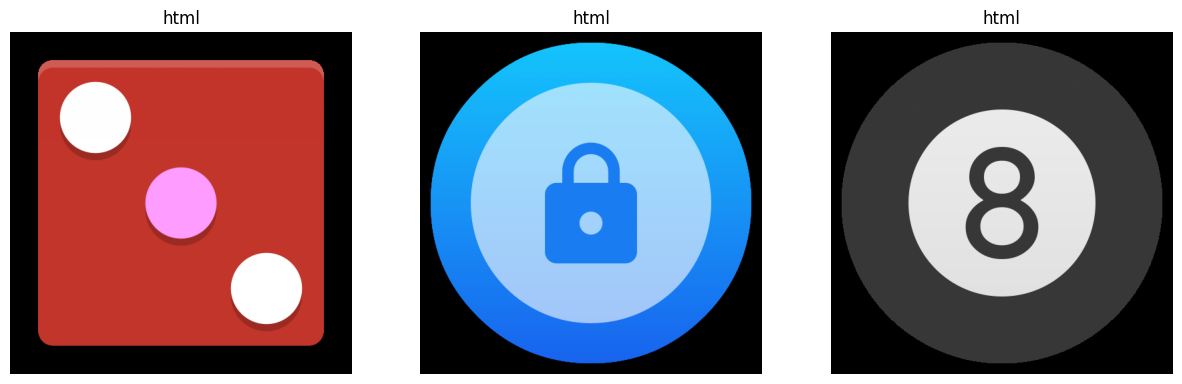


Class: js


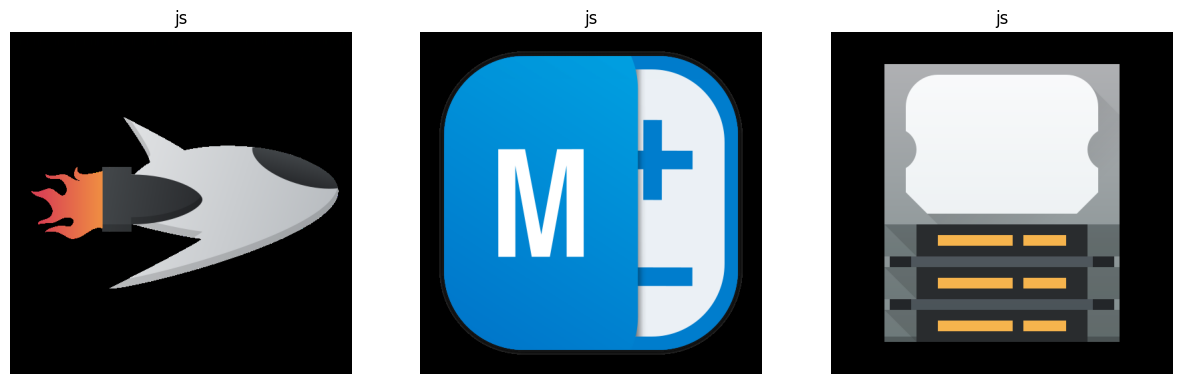


Class: ps


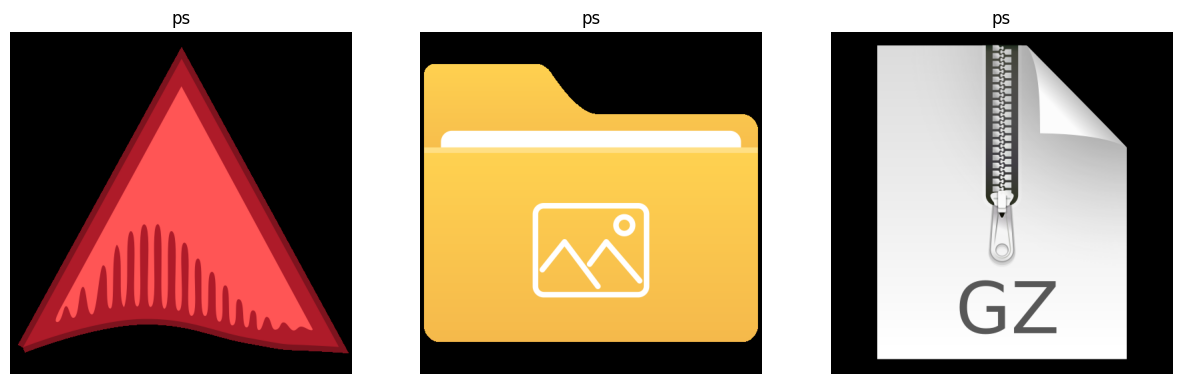


Class: url


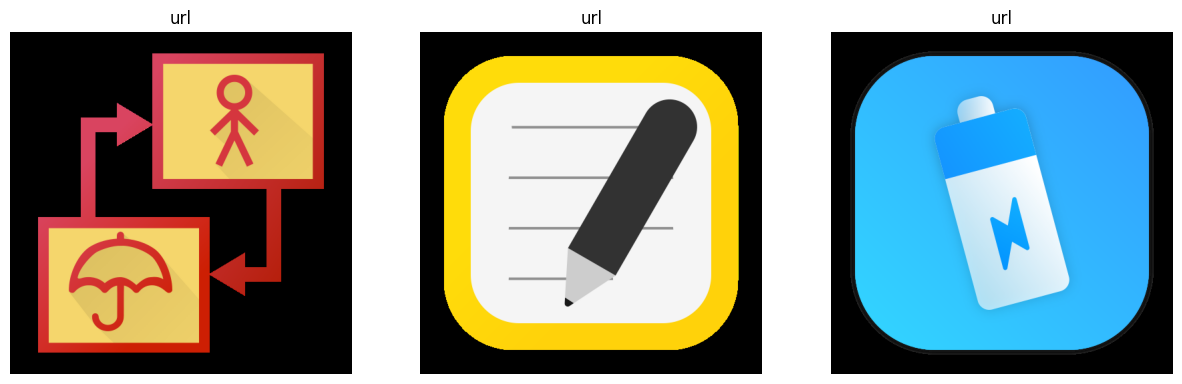

In [ ]:
# Function to display sample images from each class
def display_sample_images(data_path, num_samples=3):
    print("\nDisplaying sample images from each class...")
    for class_name in class_names:
        class_dir = os.path.join(data_path, 'train', class_name) # Use train set for samples
        if os.path.exists(class_dir):
            images = os.listdir(class_dir)
            num_to_display = min(num_samples, len(images))
            if num_to_display > 0:
                print(f"\nClass: {class_name}")
                plt.figure(figsize=(15, 5))
                for i in range(num_to_display):
                    img_path = os.path.join(class_dir, images[i])
                    img = Image.open(img_path)
                    plt.subplot(1, num_to_display, i + 1)
                    plt.imshow(img)
                    plt.title(class_name)
                    plt.axis('off')
                plt.show()
            else:
                print(f"No images found for class: {class_name}")
        else:
            print(f"Class directory not found for samples: {class_dir}")

# Display sample images (using the combined and re-split train set)
display_sample_images(final_data_path)

In [ ]:
def prepare(ds,):
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds_gen = prepare(train_dataset_gen)
val_ds_gen = prepare(val_dataset_gen)
test_ds_gen = prepare(test_dataset_gen)

train_ds_vit = prepare(train_dataset_vit)
val_ds_vit = prepare(val_dataset_vit)
test_ds_vit = prepare(test_dataset_vit)

### 3. Individual Model Definitions

In [ ]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), # input_shape must be explicitly defined here now
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu', name='feature_layer'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name="CNN_Model")
    return model

def build_cnn_rnn_model(input_shape, num_classes, rnn_type='lstm'):
    """Builds a less complex CNN-RNN model with either LSTM or GRU layers."""

    RNN_LAYER = LSTM if rnn_type.lower() == 'lstm' else GRU

    model = Sequential([
        # CNN part
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Reshape for RNN
        Reshape((-1, 64)), # Reshape to (timesteps, features) based on the last CNN layer output

        # RNN part
        Bidirectional(RNN_LAYER(64)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name=f"CNN_{rnn_type.upper()}_Model")

    return model

def build_vit_model(num_classes):
    model_name = "google/vit-base-patch16-224-in21k"
    model = TFViTForImageClassification.from_pretrained(
        model_name,
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    )
    return model

In [ ]:
input_shape_gen = (IMG_SIZE_GENERAL, IMG_SIZE_GENERAL, 3)
cnn_model = build_cnn_model(input_shape_gen, num_classes)
cnn_lstm_model = build_cnn_rnn_model(input_shape_gen, num_classes, rnn_type='lstm')
cnn_gru_model = build_cnn_rnn_model(input_shape_gen, num_classes, rnn_type='gru')
vit_model = build_vit_model(num_classes)

print("--- CNN Model Summary ---")
cnn_model.summary()
print("\n--- CNN-LSTM Model Summary ---")
cnn_lstm_model.summary()
print("\n--- CNN-GRU Model Summary ---")
cnn_gru_model.summary()
print("\n--- ViT Model (structure) ---")
print(f"ViT model loaded: {vit_model.name}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buff

--- CNN Model Summary ---


Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 124, 124, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_layer (Dense)           │ (None, 128)            │    62,980,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,074,246 (240.61 MB)

 Trainable params: 63,074,246 (240.61 MB)

 Non-trainable params: 0 (0.00 B)


--- CNN-LSTM Model Summary ---


Model: "CNN_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 15876, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,086 (367.52 KB)

 Trainable params: 94,086 (367.52 KB)

 Non-trainable params: 0 (0.00 B)


--- CNN-GRU Model Summary ---


Model: "CNN_GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 15876, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,958 (304.52 KB)

 Trainable params: 77,958 (304.52 KB)

 Non-trainable params: 0 (0.00 B)


--- ViT Model (structure) ---
ViT model loaded: tf_vi_t_for_image_classification_1


### 4. Model Training

In [ ]:
models = {
    "CNN": cnn_model,
    "CNN-LSTM": cnn_lstm_model,
    "CNN-GRU": cnn_gru_model,
}

histories = {}
trained_models = {}

vit_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

for name, model in models.items():
    print(f"\n--- Training {name} Model ---")

    if name == 'CNN':
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(
            train_ds_gen,
            validation_data=val_ds_gen,
            epochs=30,
            verbose=1
        )

    else:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(
            train_ds_gen,
            validation_data=val_ds_gen,
            epochs=10,
            verbose=1
        )

    histories[name] = history
    trained_models[name] = model
    print(f"--- {name} Model Training Complete ---")


--- Training CNN Model ---
Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 168ms/step - accuracy: 0.9436 - loss: 0.1771 - val_accuracy: 0.9809 - val_loss: 0.1024
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - accuracy: 0.9574 - loss: 0.1526 - val_accuracy: 0.9825 - val_loss: 0.0745
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - accuracy: 0.9658 - loss: 0.0945 - val_accuracy: 0.9847 - val_loss: 0.0582
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - accuracy: 0.9762 - loss: 0.0777 - val_accuracy: 0.9837 - val_loss: 0.0573
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - accuracy: 0.9847 - loss: 0.0522 - val_accuracy: 0.9850 - val_loss: 0.0650
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - accuracy: 0.9839 - loss: 0.0467 - val_accuracy: 0.9865 - val_loss: 0.0528
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - accuracy: 0.9896 - loss: 0.0374 - val_accuracy: 0.9887 - val_loss: 0.0377
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step 

In [ ]:
models["ViT"] = vit_model

In [ ]:
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    # Transpose the image data to be in channels-first format (batch_size, channels, height, width)
    image = tf.transpose(image, perm=[0, 3, 1, 2])
    return image, label


# Build the tf.data pipelines
AUTOTUNE = tf.data.AUTOTUNE

# Apply preprocessing
ds_train = train_dataset_vit.map(preprocess_image, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_val = val_dataset_vit.map(preprocess_image, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_test = test_dataset_vit.map(preprocess_image, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)


# # 5. COMPILE AND TRAIN THE MODEL
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

models["ViT"].compile(
    optimizer='adam', # Pass optimizer as a string
    loss=loss,
    metrics=['accuracy']
)

In [32]:
print("--- Starting Fine-Tuning ---")
history = models["ViT"].fit(
    ds_train,
    validation_data=ds_val,
    epochs=20
)

print("\n--- Fine-Tuning Complete ---")

--- Starting Fine-Tuning ---
Epoch 1/20
200/200 [==============================] - 150s 536ms/step - loss: 0.8093 - accuracy: 0.6367 - val_loss: 0.3130 - val_accuracy: 0.8796
Epoch 2/20
200/200 [==============================] - 103s 513ms/step - loss: 0.3573 - accuracy: 0.8771 - val_loss: 0.2320 - val_accuracy: 0.9324
Epoch 3/20
200/200 [==============================] - 103s 513ms/step - loss: 0.1742 - accuracy: 0.9475 - val_loss: 0.1754 - val_accuracy: 0.9446
Epoch 4/20
200/200 [==============================] - 103s 514ms/step - loss: 0.1634 - accuracy: 0.9493 - val_loss: 0.1370 - val_accuracy: 0.9584
Epoch 5/20
200/200 [==============================] - 103s 514ms/step - loss: 0.1067 - accuracy: 0.9666 - val_loss: 0.1147 - val_accuracy: 0.9640
Epoch 6/20
200/200 [==============================] - 103s 513ms/step - loss: 0.0963 - accuracy: 0.9680 - val_loss: 0.1022 - val_accuracy: 0.9659
Epoch 7/20
200/200 [==============================] - 103s 512ms/step - loss: 0.1916 - accuracy

### 5. Individual Model Evaluation

In [33]:
def plot_roc_curve(y_true, y_pred_proba, num_classes, class_names, model_name):
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = np.trapz(tpr[i], fpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = np.trapz(tpr["micro"], fpr["micro"])

    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-class ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def evaluate_model(model, test_ds, model_name, is_vit=False):
    print(f"\n--- Evaluating {model_name} Model ---")
    y_true = np.concatenate([y for x, y in test_ds], axis=0)

    predictions_list = []
    for data_batch, labels_batch in test_ds:
        if is_vit:
            # Apply preprocessing for ViT model
            images = tf.image.convert_image_dtype(data_batch, dtype=tf.float32)
            images = tf.transpose(images, perm=[0, 3, 1, 2])
            # The ViT model expects a dictionary input with 'pixel_values'
            # Extract the logits from the prediction output
            preds = model.predict({'pixel_values': images}).logits
            predictions_list.append(preds)
        else:
            preds = model.predict(data_batch)
            predictions_list.append(preds)

    predictions = np.concatenate(predictions_list, axis=0)


    y_pred_proba = predictions
    if is_vit:
        # The predictions are already logits, so no need to access .logits again
        y_pred_proba = tf.nn.softmax(predictions, axis=-1).numpy()


    y_pred = np.argmax(y_pred_proba, axis=1)

    print("Multi-class Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name} (Multi-class)")
    plt.show()

    try:
        roc_auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='weighted')
        print(f"Weighted Average ROC-AUC Score (Multi-class): {roc_auc:.4f}")
        plot_roc_curve(y_true, y_pred_proba, num_classes, class_names, f"{model_name} (Multi-class)")
    except Exception as e:
        print(f"Could not calculate Multi-class ROC-AUC score: {e}")

    # Binary Classification (Clean vs Not Clean)
    print("\n--- Binary Classification Report (Clean vs. Not Clean) ---")

    # Map true labels to binary (0 for clean, 1 for not clean)
    y_true_binary = np.where(y_true == class_names.index('clean'), 0, 1)

    # Map predicted classes to binary (0 for clean, 1 for not clean)
    y_pred_binary = np.where(y_pred == class_names.index('clean'), 0, 1)

    # Calculate predicted probabilities for binary classification
    # Probability of 'clean' class is the probability of class 0
    # Probability of 'not clean' is 1 - probability of class 0
    y_pred_proba_binary = np.vstack((y_pred_proba[:, class_names.index('clean')], 1 - y_pred_proba[:, class_names.index('clean')])).T


    print("Binary Classification Report:")
    print(classification_report(y_true_binary, y_pred_binary, target_names=['clean', 'not clean']))

    cm_binary = confusion_matrix(y_true_binary, y_pred_binary)
    disp_binary = ConfusionMatrixDisplay(confusion_matrix=cm_binary, display_labels=['clean', 'not clean'])
    disp_binary.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name} (Clean vs. Not Clean)")
    plt.show()

    try:
        # ROC-AUC for binary classification
        roc_auc_binary = roc_auc_score(y_true_binary, y_pred_proba_binary[:, 1]) # Use probability of 'not clean' class
        print(f"ROC-AUC Score (Clean vs. Not Clean): {roc_auc_binary:.4f}")

        # Plot binary ROC curve
        fpr_binary, tpr_binary, _ = roc_curve(y_true_binary, y_pred_proba_binary[:, 1])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_binary, tpr_binary, label=f'ROC curve (area = {roc_auc_binary:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Binary ROC Curve for {model_name} (Clean vs. Not Clean)')
        plt.legend(loc="lower right")
        plt.show()

    except Exception as e:
        print(f"Could not calculate Binary ROC-AUC score: {e}")

In [34]:
trained_models["ViT"] = models["ViT"]


--- Evaluating CNN Model ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━

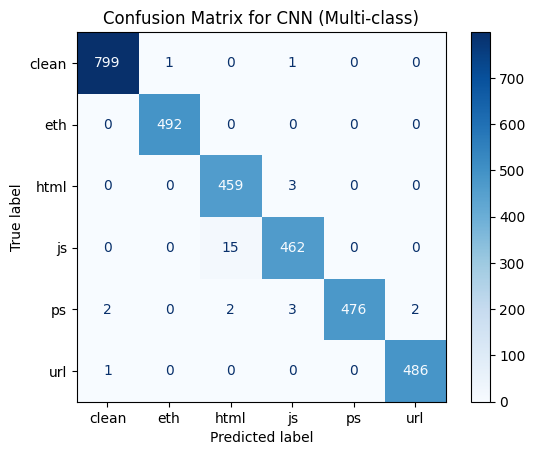

Weighted Average ROC-AUC Score (Multi-class): 0.9999


/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

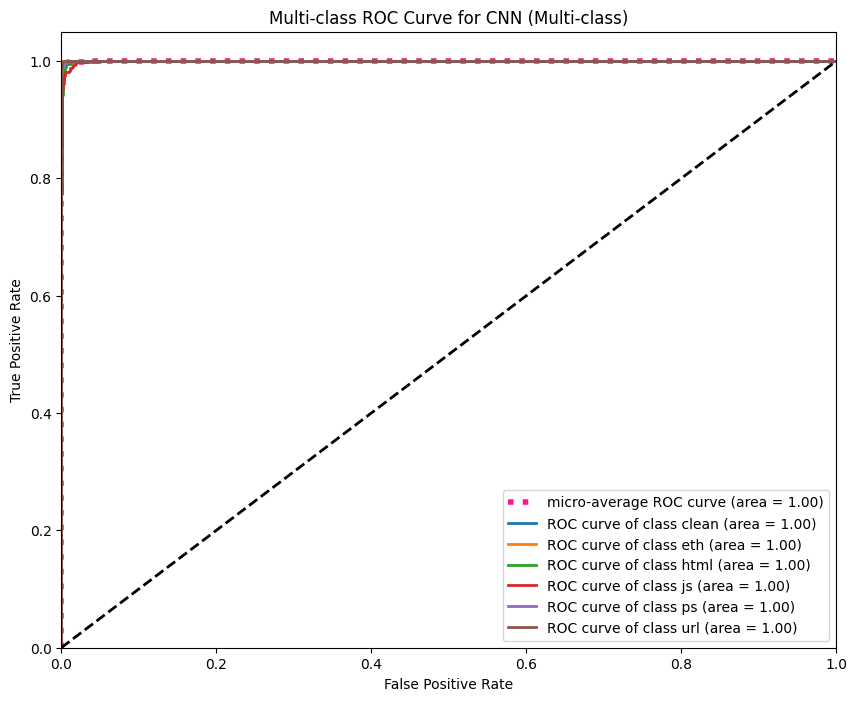


--- Binary Classification Report (Clean vs. Not Clean) ---
Binary Classification Report:
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       801
   not clean       1.00      1.00      1.00      2403

    accuracy                           1.00      3204
   macro avg       1.00      1.00      1.00      3204
weighted avg       1.00      1.00      1.00      3204



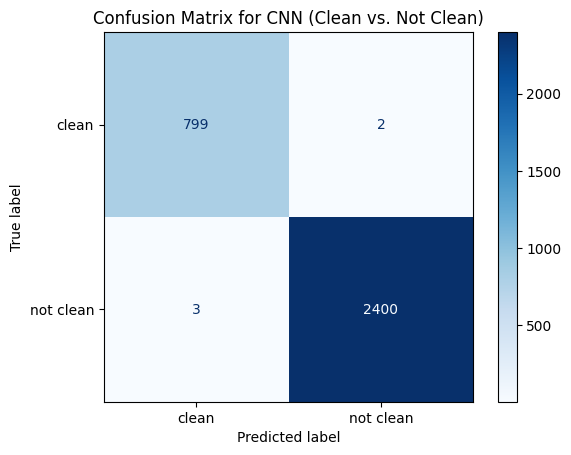

ROC-AUC Score (Clean vs. Not Clean): 1.0000


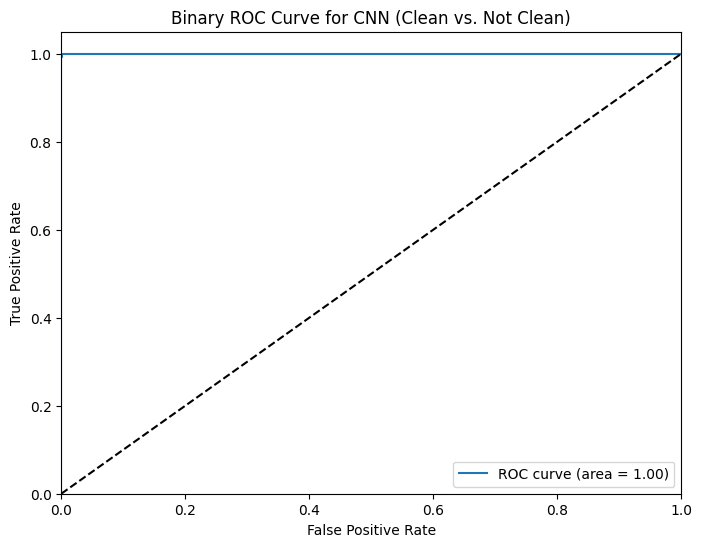


--- Evaluating CNN-LSTM Model ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 4

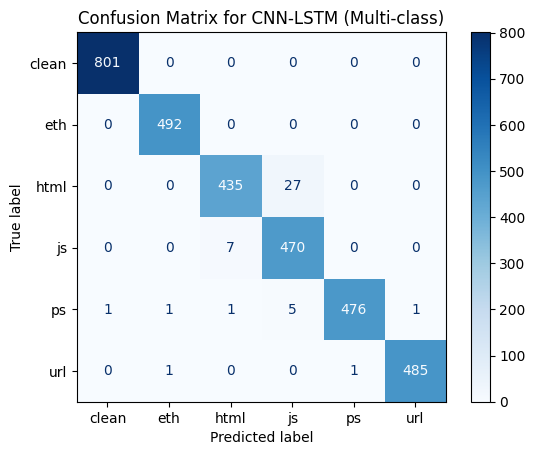

Weighted Average ROC-AUC Score (Multi-class): 0.9987


/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

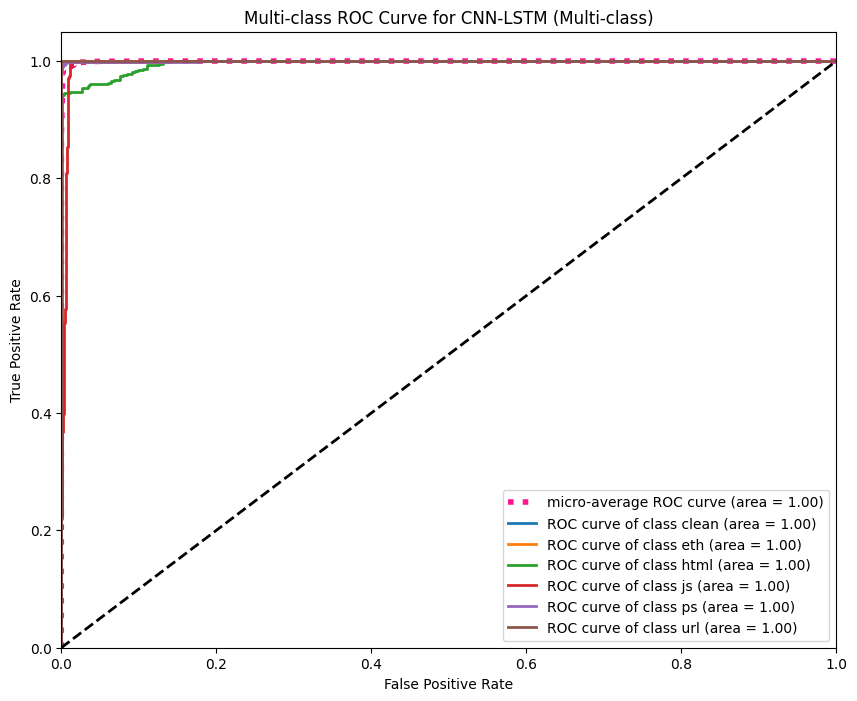


--- Binary Classification Report (Clean vs. Not Clean) ---
Binary Classification Report:
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       801
   not clean       1.00      1.00      1.00      2403

    accuracy                           1.00      3204
   macro avg       1.00      1.00      1.00      3204
weighted avg       1.00      1.00      1.00      3204



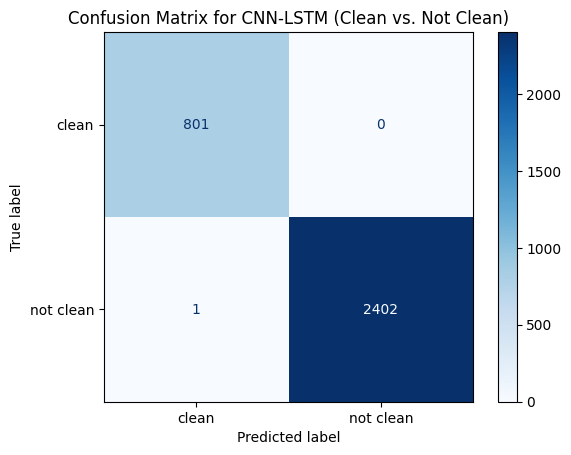

ROC-AUC Score (Clean vs. Not Clean): 1.0000


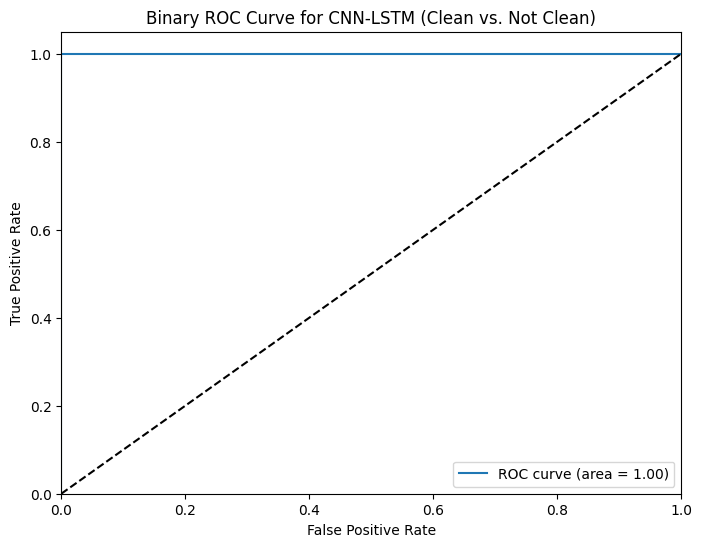


--- Evaluating CNN-GRU Model ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 44

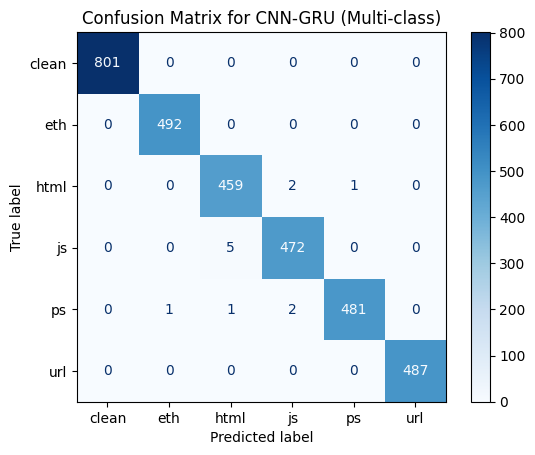

Weighted Average ROC-AUC Score (Multi-class): 1.0000


/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

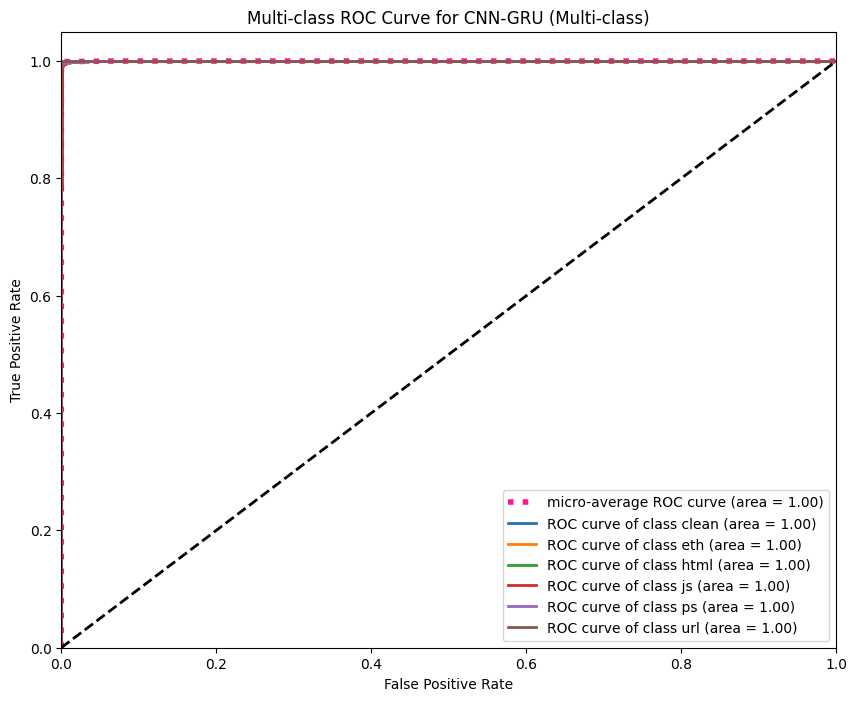


--- Binary Classification Report (Clean vs. Not Clean) ---
Binary Classification Report:
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       801
   not clean       1.00      1.00      1.00      2403

    accuracy                           1.00      3204
   macro avg       1.00      1.00      1.00      3204
weighted avg       1.00      1.00      1.00      3204



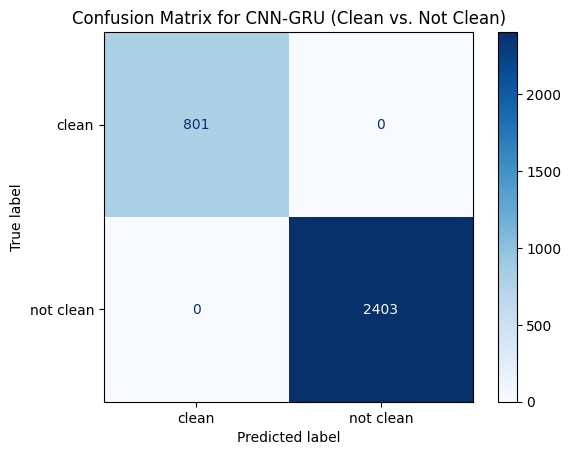

ROC-AUC Score (Clean vs. Not Clean): 1.0000


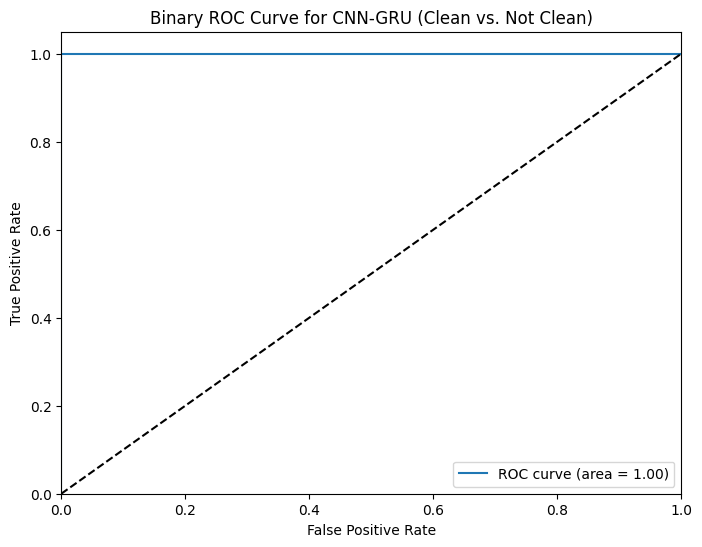


--- Evaluating ViT Model ---
1/1 [==============================] - 3s 3s/step
Multi-class Classification Report:
              precision    recall  f1-score   support

       clean       0.99      0.99      0.99       801
         eth       0.96      0.99      0.97       492
        html       0.94      0.98      0.96       462
          js       0.99      0.92      0.96       477
          ps       1.00      0.98      0.99       485
         url       0.97      0.99      0.98       487

    accuracy                           0.98      3204
   macro avg       0.97      0.97      0.97      3204
weighted avg       0.98      0.98      0.98      3204



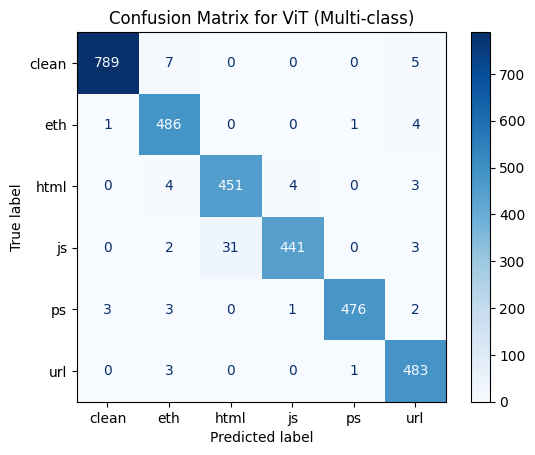

Weighted Average ROC-AUC Score (Multi-class): 0.9992


/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-33-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

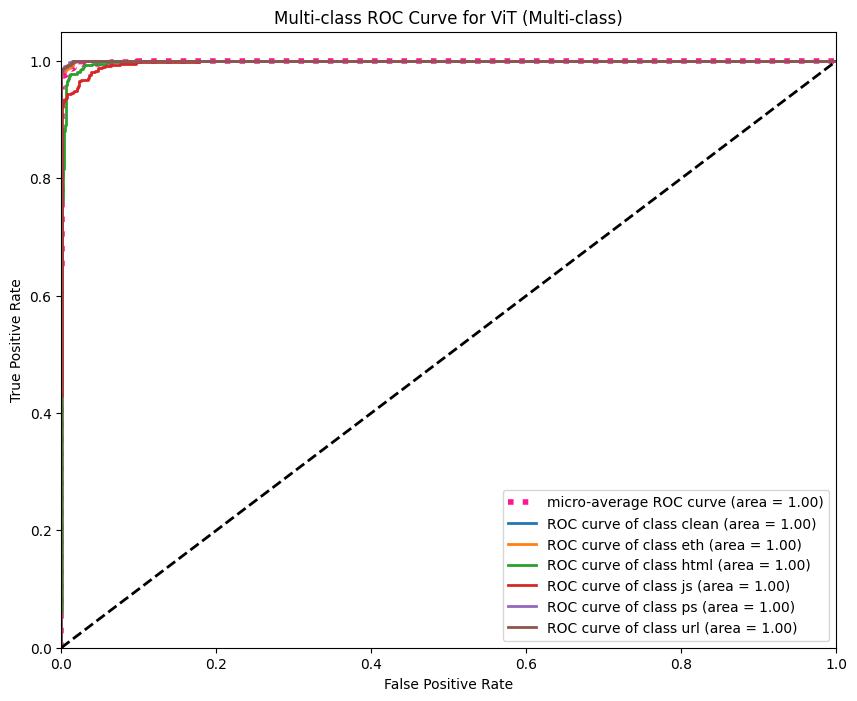


--- Binary Classification Report (Clean vs. Not Clean) ---
Binary Classification Report:
              precision    recall  f1-score   support

       clean       0.99      0.99      0.99       801
   not clean       1.00      1.00      1.00      2403

    accuracy                           1.00      3204
   macro avg       0.99      0.99      0.99      3204
weighted avg       1.00      1.00      0.99      3204



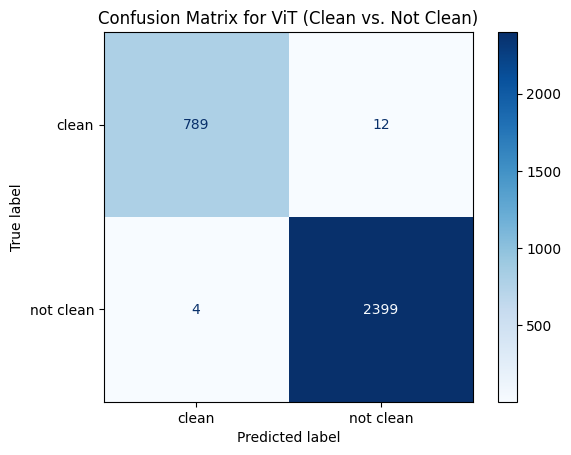

ROC-AUC Score (Clean vs. Not Clean): 0.9999


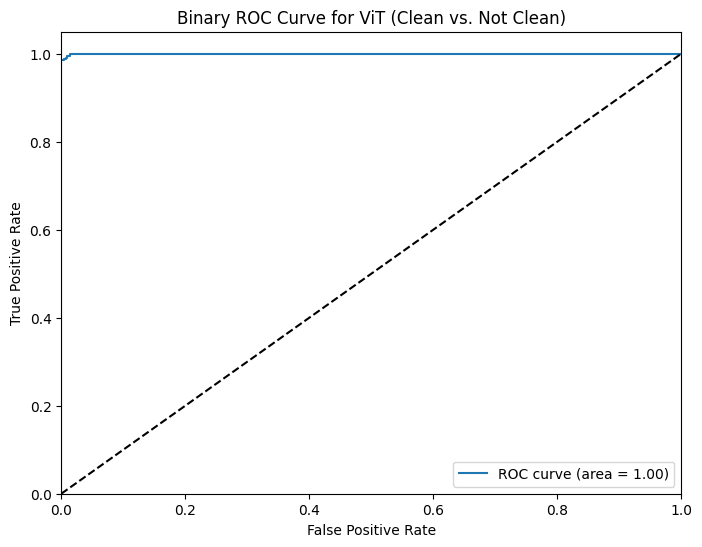

In [35]:
for name, model in trained_models.items():
    is_vit_model = (name == "ViT")
    current_test_ds = test_ds_vit if is_vit_model else test_ds_gen

    evaluate_model(model, current_test_ds, name, is_vit=is_vit_model)

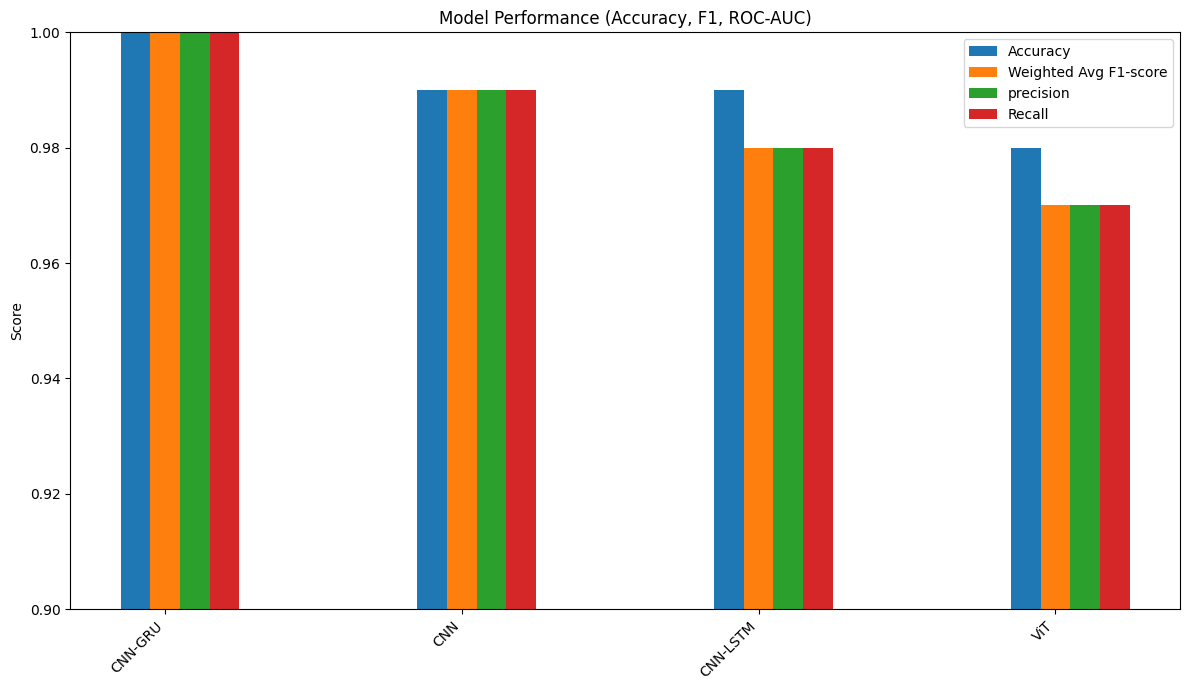

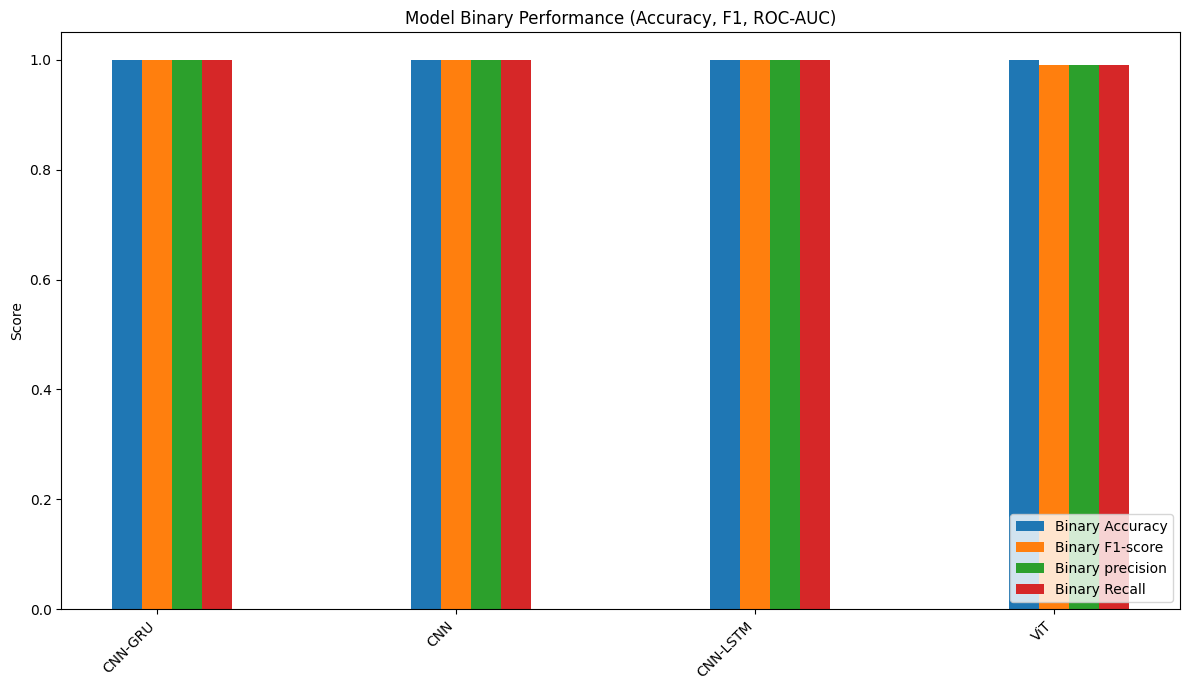

In [65]:
import matplotlib.pyplot as plt
import numpy as np

df_results_sorted = df_results_sorted.sort_values(by="Accuracy", ascending=False)
models = df_results_sorted.index
metrics_performance = ['Accuracy', 'Weighted Avg F1-score','precision', 'Recall']
metrics_binary = ['Binary Accuracy', 'Binary F1-score', 'Binary precision', 'Binary Recall']

x = np.arange(len(models))
width = 0.1

# Plotting Performance Metrics
fig1, ax1 = plt.subplots(figsize=(12, 7))

for i, metric in enumerate(metrics_performance):
    ax1.bar(x + i * width, df_results_sorted[metric], width, label=metric)

ax1.set_ylabel('Score')
ax1.set_title('Model Performance (Accuracy, F1, ROC-AUC)')
ax1.set_xticks(x + width)
ax1.set_ylim(0.9, 1)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
plt.tight_layout()
plt.show()

# Plotting Binary Performance Metrics
fig2, ax2 = plt.subplots(figsize=(12, 7))

for i, metric in enumerate(metrics_binary):
    ax2.bar(x + i * width, df_results_sorted[metric], width, label=metric)

ax2.set_ylabel('Score')
ax2.set_title('Model Binary Performance (Accuracy, F1, ROC-AUC)')
ax2.set_xticks(x + width)
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()